In [1]:
%matplotlib inline

from datetime import datetime 
import h5py
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
cmap = cm.get_cmap('Blues')
import random
from numpy.linalg import lstsq

import matplotlib as mpl
mpl.rcParams["image.interpolation"] = 'none'

In [2]:
#read hdf5 file for this notebook
f1 = h5py.File("Data/FigS06_ijkl.hdf5", "r")

#get the data for plotting the sd image
dataCh0 = np.array(f1['dataCh0'])
roimask = np.array(f1['roimask'])
x_zoom = np.array(f1['x_zoom'])

f1.close()

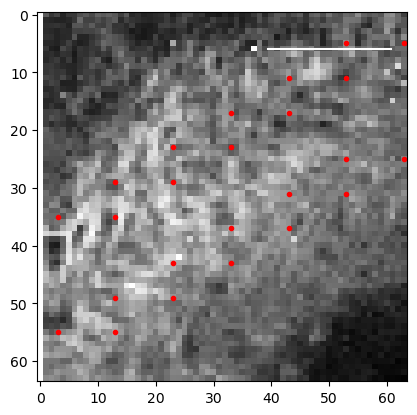

In [3]:
#calculate std
std = np.std(dataCh0, axis=2)  # standard deviation across time
mean_stack = np.mean(dataCh0, axis=2)

# plt.imshow(std.T, vmax=20, cmap="Greys_r")
plt.imshow(std.T, cmap='Greys_r', vmax=10) #, origin='upper'
# plt.imshow(mean_stack.T, cmap='Greys_r')#, vmax=15)

box = str(1)
xcoords1=[13, 3, 13, 3]
ycoords1=[55, 55, 35, 35]

box = str(2)
xcoords2=[23, 13, 23, 13]
ycoords2=[49, 49, 29, 29]

box = str(3)
xcoords3=[33, 23, 33, 23]
ycoords3=[43, 43, 23, 23]

box = str(4)
xcoords4=[43, 33, 43, 33]
ycoords4=[37, 37, 17, 17]

box = str(5)
xcoords5=[53, 43, 53, 43]
ycoords5=[31, 31, 11, 11]

box = str(6)
xcoords6=[63, 53, 63, 53]
ycoords6=[25, 25, 5, 5]

box=str(7)
plt.plot(xcoords1, ycoords1, color='r', linestyle='None', marker='.')
plt.plot(xcoords2, ycoords2, color='r', linestyle='None', marker='.')
plt.plot(xcoords3, ycoords3, color='r', linestyle='None', marker='.')
plt.plot(xcoords4, ycoords4, color='r', linestyle='None', marker='.')
plt.plot(xcoords5, ycoords5, color='r', linestyle='None', marker='.')
plt.plot(xcoords6, ycoords6, color='r', linestyle='None', marker='.')


#scale bar business

total_length = 65/x_zoom#(71.5/x_zoom)
scale_bar_microns = 40
scale_bar_start = 75
plt.axhline(y=6, xmin=scale_bar_start/total_length, xmax=(scale_bar_microns+scale_bar_start)/total_length, color='white')
# plt.axvline(x=31)
# Figpath = 'Fig_temp/'
# savename = Figpath+"Meso_loom_std_scalebar_40_um_box"+box+".pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()

In [4]:
np.amax(mean_stack), np.amin(mean_stack)

(10996.9861003861, 10942.90888030888)

# Plot Field Average

In [5]:
#pull this data from the hdf5 file
data_df = pd.read_hdf('Data/FigS06_ijkl.hdf5', 'snippet_data_df')

In [6]:
field_average = data_df.groupby(['directions', 'time_bin']).mean()

# plot a localized field average

In [8]:
data_df

preprocess_snippets
roi_ids directions time_bin                     
1       0          0.00                 0.249660
                   0.05                -0.162282
                   0.10                -0.318220
                   0.15                -0.341423
                   0.20                -0.373022
...                                          ...
2048    1          3.10                -0.110750
                   3.15                -0.128303
                   3.20                -0.382367
                   3.25                 0.195911
                   3.30                 0.061192

[274432 rows x 1 columns]

In [13]:
#find where maximum responses are happening

# data_df[data_df.index.to_frame['time_bin'].between(1,2)]
mask_start = 1.1
mask_end = 1.6
tpnts = data_df.index.get_level_values('time_bin')
timemask = (tpnts > mask_start) & (tpnts < mask_end)
data_df_masked = data_df.loc[(slice(None), slice(None), timemask), :]
data_max = data_df_masked['preprocess_snippets'].groupby(['roi_ids','directions']).max()

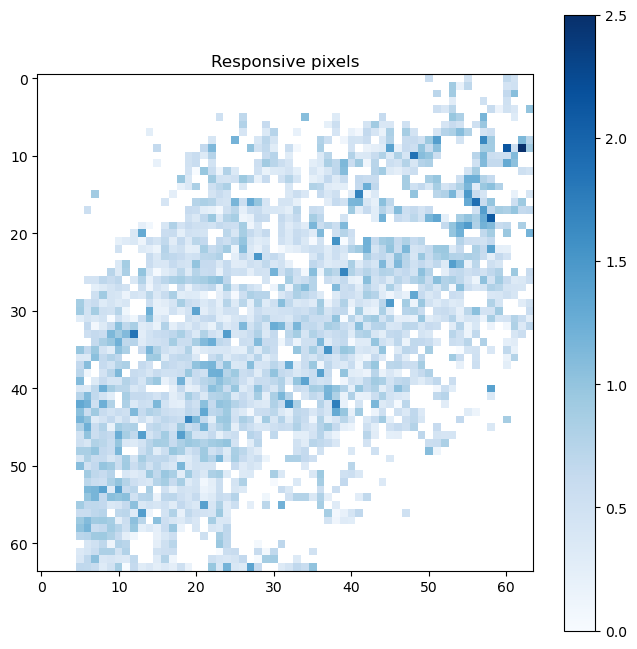

In [14]:

direction = 1
ds_rois = data_max.index.to_frame(index=False)['roi_ids'].unique()
# perm_df_sig_group = perm_df_sig.loc[group]
dsmap = roimask*(-1)

xlength = dsmap.shape[0]
ylength = dsmap.shape[1]

for x in range(xlength):
    for y in range(ylength):  
        if dsmap[x,y] in ds_rois:
            roi_index = np.int(dsmap[x, y])
            dsmap[x,y] = data_max.loc[(roi_index, direction)]
        else:
            if dsmap[x,y]>0:
                dsmap[x,y] = np.nan
            else:
                dsmap[x,y] = np.nan


plt.figure(figsize=(8, 8))
plt.title('Responsive pixels')
plt.imshow(dsmap.T, cmap='Blues',vmin=0, vmax=2.5)#, origin='lower') #  vmin=0, vmax=1.5,
cb = plt.colorbar()
#cb.remove()
# plt.draw()
# if plotsave == True:
#     savename = Figpath+"DS_map_ds_rois300_lengths300.pdf"
#     plt.savefig(savename, transparent=True, bbox_inches='tight')

# Figpath = 'Fig_temp/'
# savename = Figpath+"X_dsi_map.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()

In [15]:
def get_square(x_c, y_c, width, x_zoom, roimask):
    #center in pixel coordinates, width in um from stimulus
    um_per_pixel = 71.5/x_zoom/roimask.shape[0]
    width_pixels = width/um_per_pixel
    print(width_pixels)
    x = []
    y = []
    x.append(x_c-width_pixels/2)
    x.append(x_c+width_pixels/2)
    x.append(x_c-width_pixels/2)
    x.append(x_c+width_pixels/2)
    y.append(y_c-width_pixels/2)
    y.append(y_c-width_pixels/2)
    y.append(y_c+width_pixels/2)
    y.append(y_c+width_pixels/2)
    
    square_coordinates = np.column_stack((x,y))

    
    return square_coordinates #x, y

In [16]:
coord = get_square(8, 45, 20, x_zoom, roimask)

9.66713286713287


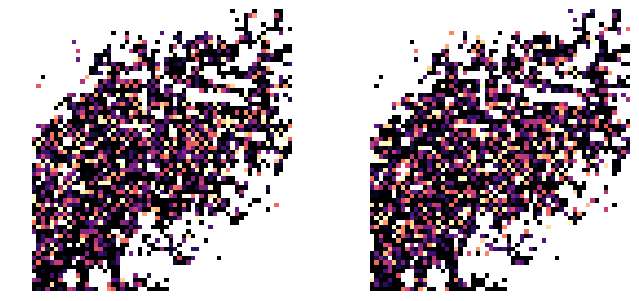

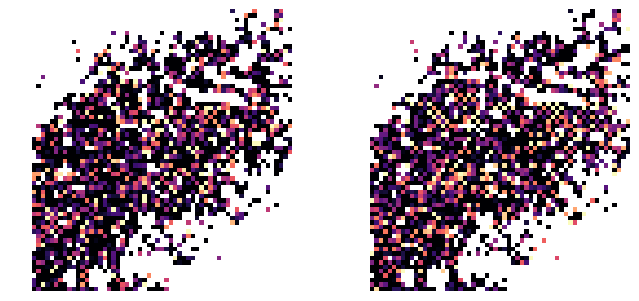

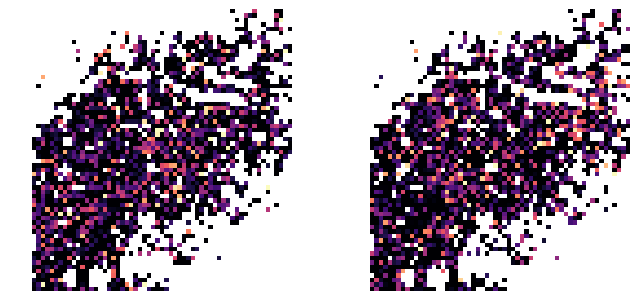

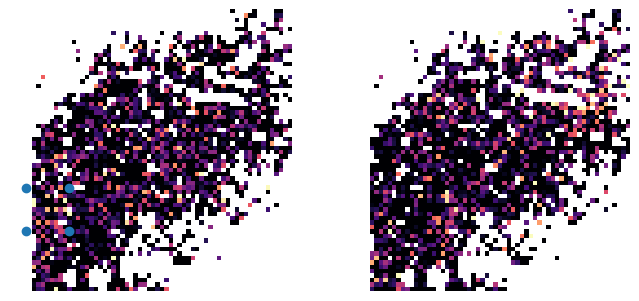

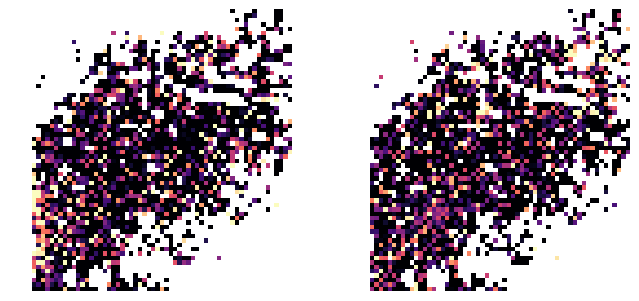

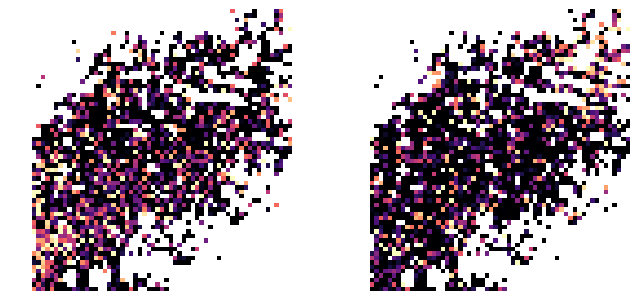

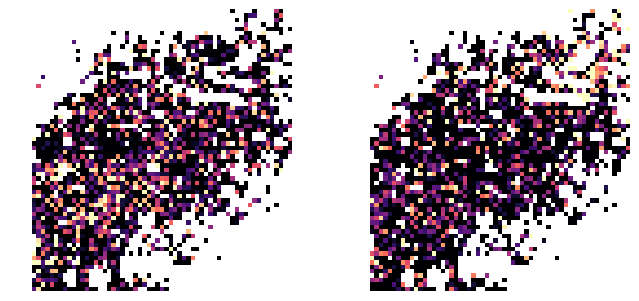

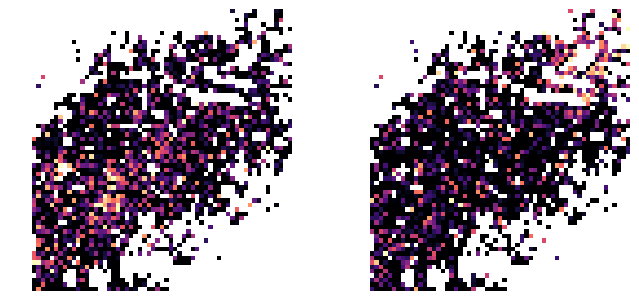

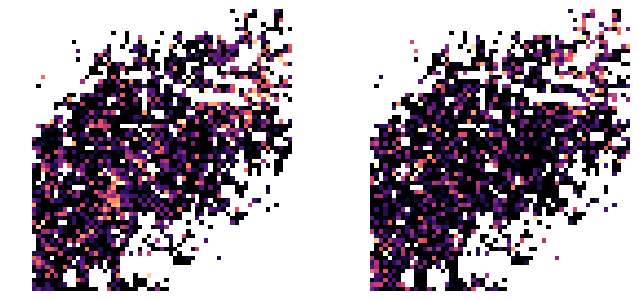

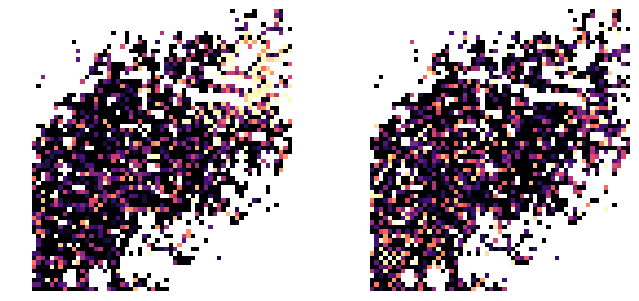

In [18]:
%matplotlib inline
# times = [1.5, 1.6, 1.7, 1.9, 2.1, 2.3, 2.5, 2.7]
# times = [1.5, 1.7, 1.9, 2.1, 2.3, 2.5, 2.7]

times = [1.05,1.1,1.15,1.2,1.25,1.3,1.35,1.4,1.45,1.5]#,1.6,1.7,1.8,1.9,2.0]
# times = [0.0, 0.5, 1.0, 1.5, 2.0]


for start in times:
    mask_start = start
    mask_end = mask_start+0.1
    tpnts = data_df.index.get_level_values('time_bin')
    timemask = (tpnts > mask_start) & (tpnts < mask_end)
    data_df_masked = data_df.loc[(slice(None), slice(None), timemask), :]
    data_mean = data_df_masked['preprocess_snippets'].groupby(['roi_ids','directions']).mean()
    
    xlength = roimask.shape[0]
    ylength = roimask.shape[1]
    ds_rois = data_max.index.to_frame(index=False)['roi_ids'].unique()
    
    #make first condition DS mask
    direction1 = 1
    dsmap1 = roimask.T*(-1)
    for x in range(xlength):
        for y in range(ylength):  
            if dsmap1[x,y] in ds_rois:
                roi_index = np.int(dsmap1[x, y])
                dsmap1[x,y] = data_mean.loc[(roi_index, direction1)]
            else:
                dsmap1[x,y] = np.nan
    
    #make second condition DS mask
    direction2 = 0
    dsmap2 = roimask.T*(-1)
    for x in range(xlength):
        for y in range(ylength):  
            if dsmap2[x,y] in ds_rois:
                roi_index = np.int(dsmap2[x, y])
                dsmap2[x,y] = data_mean.loc[(roi_index, direction2)]
            else:
                dsmap2[x,y] = np.nan



    fig = plt.figure(figsize=(8, 8))
#     plt.title('Responsive pixels')
    
    ax = fig.add_subplot(1,2,1)
    plt.imshow(dsmap1, cmap='magma', vmin=0.0, vmax=0.7)
    ax.set_facecolor('k')
#     plt.imshow(dsmap1, cmap='Blues', vmin=0, vmax=2, origin='lower')
    if start ==1.2:
        plt.scatter(coord[:,0],coord[:,1])
    plt.axis('off')
    
    ax = fig.add_subplot(1,2,2)
    plt.imshow(dsmap2, cmap='magma', vmin=0.0, vmax=0.7)
    ax.set_facecolor('k')
#     plt.imshow(dsmap2, cmap='Blues', vmin=0, vmax=2, origin='lower')
#     plt.scatter(coord[:,0],coord[:,1])
    plt.axis('off')
    
#     cb = plt.colorbar()
    #cb.remove()
    # plt.draw()
    # if plotsave == True:
    #     savename = Figpath+"DS_map_ds_rois300_lengths300.pdf"
    #     plt.savefig(savename, transparent=True, bbox_inches='tight')

#     Figpath = 'Fig_temp/'
#     savename = Figpath+"Meso_montage_loom_time"+str(start)+".pdf"
#     plt.savefig(savename, transparent=True, bbox_inches='tight')

    plt.show()

In [19]:
def get_rois(roimask, x_c, y_c, width, length):
    ybottom = np.int(y_c-length/2)
    ytop = np.int(y_c+length/2)
    xbottom = np.int(x_c-width/2)
    xtop = np.int(x_c+width/2)

    rois = []
    area = roimask*(-1)
    for x in range(xbottom, xtop):
        for y in range(ybottom, ytop):
            if area[x,y]>0:
                rois.append(np.int(area[x,y]))
    print(xbottom,xtop,ybottom,ytop)
    return rois

3 13 35 55
80.0
0.741629669360111
0.37786318120361656


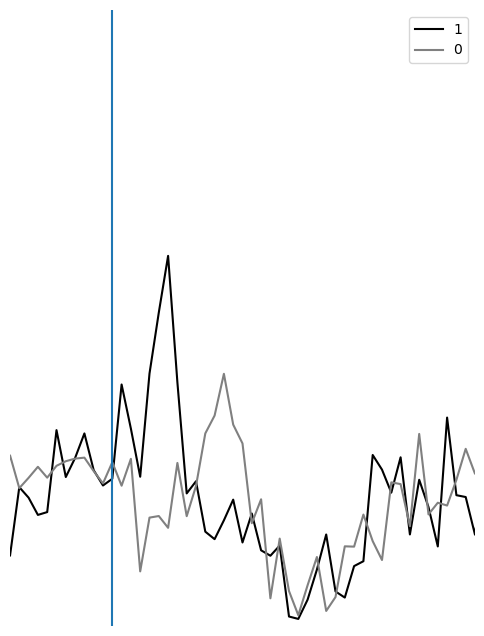

13 23 29 49
98.80787037037037
0.37674935067985255
0.4020305907024739


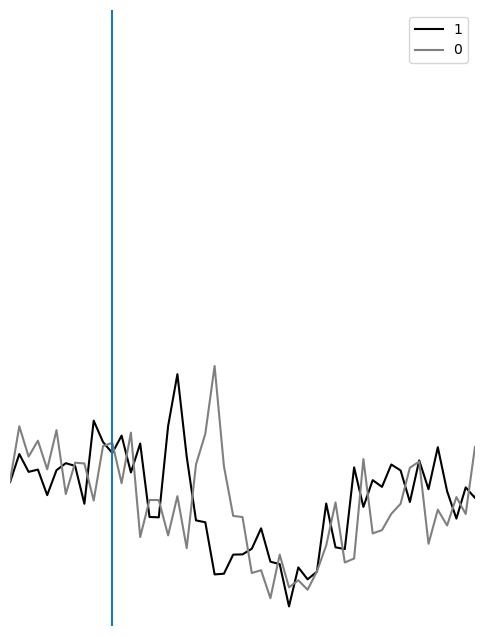

23 33 23 43
117.61574074074073
0.23625614533480002
0.3038441472342529


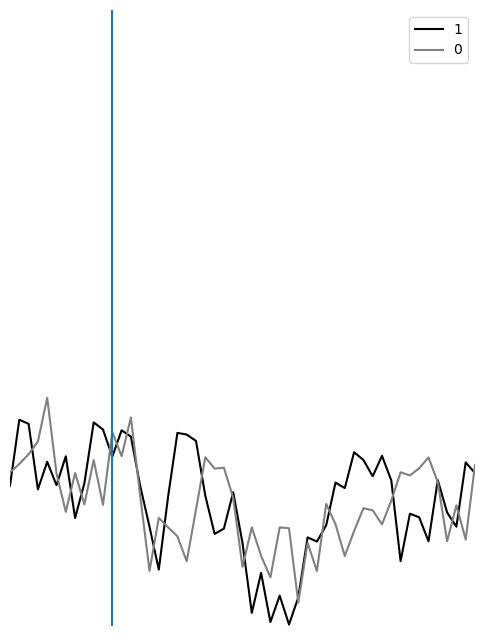

33 43 17 37
136.42361111111111
0.2660644471756408
0.23444423317290575


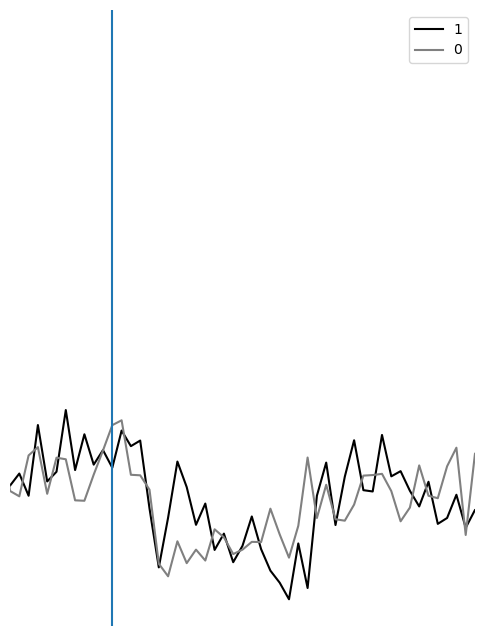

43 53 11 31
155.23148148148147
0.5097446960628983
0.33265398266264495


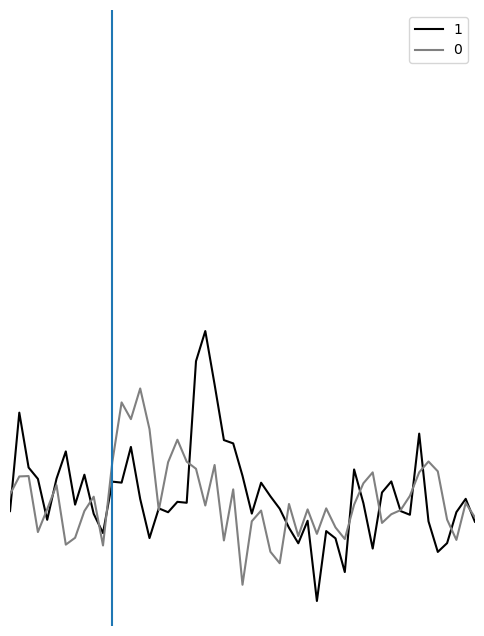

53 63 5 25
174.03935185185185
1.4654856907627214
0.5933512053616803


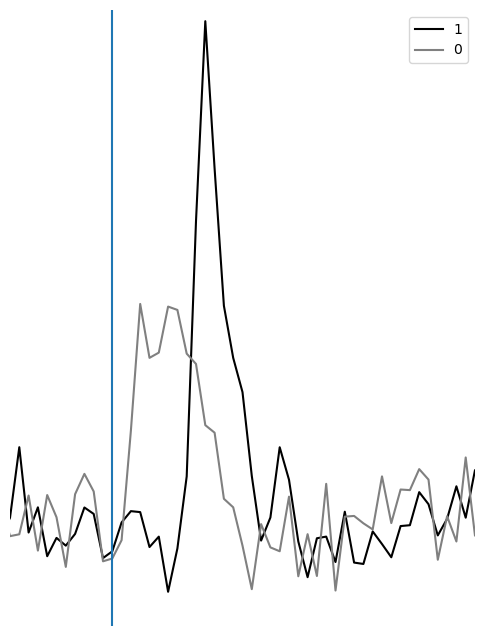

In [20]:
# responses in a rolling window across the field

max_all = np.zeros((6,3))
position_step = ((65/x_zoom)/64)*10
ii=0
for i, val in enumerate(range(8,63,10)):
    rois = get_rois(roimask, val, 45-ii, 10, 20)
    ii+=6
    box_responses = data_df.loc[rois].copy()
    mean_responses = box_responses['preprocess_snippets'].mean()
    std_responses = box_responses['preprocess_snippets'].std()

    box_responses['preprocess_snippets_zscored'] = (box_responses['preprocess_snippets'] - mean_responses)/std_responses

    area_means = box_responses.groupby(['directions', 'time_bin']).mean()
    area_stds = box_responses.groupby(['directions', 'time_bin']).std()

    plt.figure(figsize=(6, 8))
    directions = area_means.index.to_frame(index=False)['directions'].unique()
    # lengths = area_means.index.to_frame(index=False)['lengths'].unique()
    directions = [1, 0]
    # lengths = [100]

    max_all[i,0] = position_step*(i)+80
    print(position_step*(i)+80)
    
    colors = ['black', 'grey', 'yellow', 'magenta', 'red', 'green', 'purple', 'black']

    index = 1
    for direction in directions:


            xval = area_means['preprocess_snippets_zscored'].loc[(direction)].index.to_frame(index=False)['time_bin']
            plt.plot(xval, area_means['preprocess_snippets_zscored'].loc[(direction)], color=colors[index-1], label=str(direction))
#             std_top =area_means['preprocess_snippets_zscored'].loc[(direction)] + area_stds['preprocess_snippets_zscored'].loc[(direction)]
#             std_bottom=area_means['preprocess_snippets_zscored'].loc[(direction)] - area_stds['preprocess_snippets_zscored'].loc[(direction)]
#             plt.fill_between(xval, std_top, std_bottom, alpha=0.5)
            index+=1
            
            max_all[i,direction+1]=area_means['preprocess_snippets_zscored'].loc[(direction)].max()

            print(area_means['preprocess_snippets_zscored'].loc[(direction)].max())
    plt.legend()
    axes = plt.gca()
    axes.set_xlim([0.5, 3])
    axes.set_ylim([-0.4, 1.5])
    axes.axis('off')
    axes.axvline(x=1.05)

#     Figpath = 'Fig_temp/'
#     savename = Figpath+"Meso_loom_response_"+str(i)+".pdf"
#     plt.savefig(savename, transparent=True, bbox_inches='tight')

    plt.show()

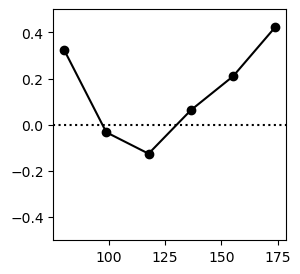

In [21]:
fig = plt.figure(figsize=(3,3))
plt.plot(max_all[:,0],(max_all[:,2]-max_all[:,1])/(max_all[:,2]+max_all[:,1]), c='k', linestyle='solid', marker='o')
# plt.plot(, c='k')

axes=plt.gca()
axes.set_ylim([-0.5,0.5])
axes.axhline(y=0,c='k',linestyle='dotted')

# Figpath = 'Fig_temp/'
# savename = Figpath+"Meso_loom_response_LSI.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')